In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from geobr import read_municipality
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen
from splot.esda import moran_scatterplot

In [27]:
def load_piaui_data(year):
    """
    Carrega os limites municipais do Piauí para o ano especificado e
    mescla com os dados reais de internações presentes no arquivo CSV "data/I_internacao.csv".
    
    O CSV possui a estrutura:
        Município,2010,2011,2012,...,2023
    onde a coluna 'Município' contém, por exemplo, "220010 AGRICOLANDIA".
    Os 6 primeiros caracteres são usados para extrair o código do município.
    """
    # Carrega os limites municipais do Piauí para o ano
    piaui = read_municipality(code_muni="PI", year=year)
    
    # Carrega os dados reais de internações com encoding apropriado (ex: latin1)
    df = pd.read_csv("data/I_internacao.csv", encoding="latin1")
    
    # Extrai o código do município dos 6 primeiros caracteres da coluna "Município"
    df["code_muni"] = df["Município"].astype(str).str[:6]
    
    # Seleciona a coluna do ano desejado, substitui '-' por '0' e converte para numérico
    col_year = str(year)
    df[col_year] = df[col_year].replace("-", "0")
    df[col_year] = pd.to_numeric(df[col_year], errors='coerce').fillna(0)
    
    # Mantém apenas as colunas relevantes e renomeia a coluna do ano para 'internacoes'
    df = df[["code_muni", col_year]].rename(columns={col_year: "internacoes"})
    
    # Força a conversão da coluna de código para string em ambos os DataFrames
    piaui["code_muni"] = piaui["code_muni"].astype(str)
    df["code_muni"] = df["code_muni"].astype(str)
    
    # Realiza o merge dos dados reais com os limites geográficos
    piaui = piaui.merge(df, on="code_muni", how="left")
    
    # Preenche valores ausentes com 0 e adiciona a coluna 'ano'
    piaui["internacoes"] = piaui["internacoes"].fillna(0)
    piaui["ano"] = year
    
    return piaui

def plot_choropleth(gdf, title="Mapa Coroplético - Internações"):
    """
    Plota o mapa coroplético da variável 'internacoes' com estilo inspirado no exemplo do Ipea.
    """
    # Atualiza parâmetros de fonte
    plt.rcParams.update({"font.size": 8})
    fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
    
    # Plota o choropleth com legenda customizada
    gdf.plot(
        column="internacoes",
        cmap="OrRd",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        legend_kwds={
            "label": "Número de Internações",
            "orientation": "horizontal",
            "shrink": 0.6,
        },
        ax=ax,
    )
    ax.set_title(title, fontsize=12)
    ax.axis("off")
    plt.show()

def compute_moran(gdf):
    """
    Calcula o Índice de Moran Global para a variável 'internacoes' e o retorna.
    Se a variabilidade for nula, retorna None.
    """
    if gdf["internacoes"].std() < 1e-8:
        print("Variável 'internacoes' é constante ou quase constante. Índice de Moran não pode ser calculado.")
        return None
    w = Queen.from_dataframe(gdf, use_index=False)
    w.transform = "r"
    moran_global = Moran(gdf["internacoes"], w)
    print(f"Índice de Moran Global: {moran_global.I:.4f}")
    print(f"p-valor: {moran_global.p_sim:.4f}")
    return moran_global

def plot_moran_scatter(gdf, title="Moran Scatterplot - Internações"):
    """
    Plota o scatterplot do Índice de Moran Global.
    Se o valor de Moran for nan, exibe mensagem de aviso.
    """
    gdf = gdf.dropna(subset=["internacoes"])
    w = Queen.from_dataframe(gdf, use_index=False)
    w.transform = "r"
    moran_global = Moran(gdf["internacoes"], w)
    
    if np.isnan(moran_global.I):
        print("Moran's I é nan (possivelmente devido à variabilidade nula). Scatterplot não pode ser gerado.")
        return
    
    fig, ax = moran_scatterplot(moran_global)
    ax.set_title(title, fontsize=12)
    plt.show()

def compute_lisa(gdf):
    """
    Calcula o Moran Local (LISA) e adiciona a coluna 'LISA_Cluster' ao GeoDataFrame.
    Os clusters são classificados em:
      - HH: Alta-Alta
      - LL: Baixa-Baixa
      - LH: Baixa-Alta
      - HL: Alta-Baixa
      - Não Significativo: onde a autocorrelação não é estatisticamente significativa
    """
    w = Queen.from_dataframe(gdf, use_index=False)
    w.transform = "r"
    lisa = Moran_Local(gdf["internacoes"], w)
    gdf["LISA_Cluster"] = "Não Significativo"
    significant = lisa.p_sim < 0.05
    gdf.loc[significant & (lisa.q == 1), "LISA_Cluster"] = "HH"
    gdf.loc[significant & (lisa.q == 2), "LISA_Cluster"] = "LH"
    gdf.loc[significant & (lisa.q == 3), "LISA_Cluster"] = "LL"
    gdf.loc[significant & (lisa.q == 4), "LISA_Cluster"] = "HL"
    return lisa, gdf

def plot_lisa(gdf, title="Mapa de Clusters LISA - Internações"):
    """
    Plota o mapa temático dos clusters LISA com cores definidas para cada categoria.
    Verifica se os limites das geometrias são válidos e plota apenas os subconjuntos não vazios.
    """
    bounds = gdf.total_bounds  # [xmin, ymin, xmax, ymax]
    if (np.any(np.isnan(bounds)) or np.any(np.isinf(bounds)) or 
        (bounds[2] - bounds[0] <= 0) or (bounds[3] - bounds[1] <= 0)):
        print("Geometrias não possuem limites válidos para plotagem.")
        return

    fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
    ax.set_aspect('equal')
    
    colors = {
        "HH": "red",
        "LL": "blue",
        "LH": "lightblue",
        "HL": "pink",
        "Não Significativo": "gray"
    }
    
    for cluster, color in colors.items():
        subset = gdf[gdf["LISA_Cluster"] == cluster]
        if not subset.empty:
            subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.8)
    
    legend_handles = [mpatches.Patch(color=color, label=cluster) for cluster, color in colors.items()]
    ax.legend(handles=legend_handles, title="Clusters LISA", loc="upper right", fontsize=8)
    ax.set_title(title, fontsize=12)
    ax.axis("off")
    plt.show()

def analyze_years(years):
    """
    Para cada ano especificado, gera:
      - Mapa coroplético das internações
      - Cálculo e scatterplot do Índice de Moran Global
      - Cálculo e mapa dos clusters LISA
    """
    for year in years:
        print(f"\nAnalisando o ano {year}...")
        gdf = load_piaui_data(year)
        
        # Mapa Coroplético
        plot_choropleth(gdf, title=f"Mapa Coroplético - Internações {year}")
        
        # Índice de Moran Global e Scatterplot
        moran_global = compute_moran(gdf)
        plot_moran_scatter(gdf, title=f"Moran Scatterplot - Internações {year}")
        
        # Análise LISA e Mapa de Clusters LISA
        lisa, gdf = compute_lisa(gdf)
        plot_lisa(gdf, title=f"Mapa de Clusters LISA - Internações {year}")


Analisando o ano 2013...


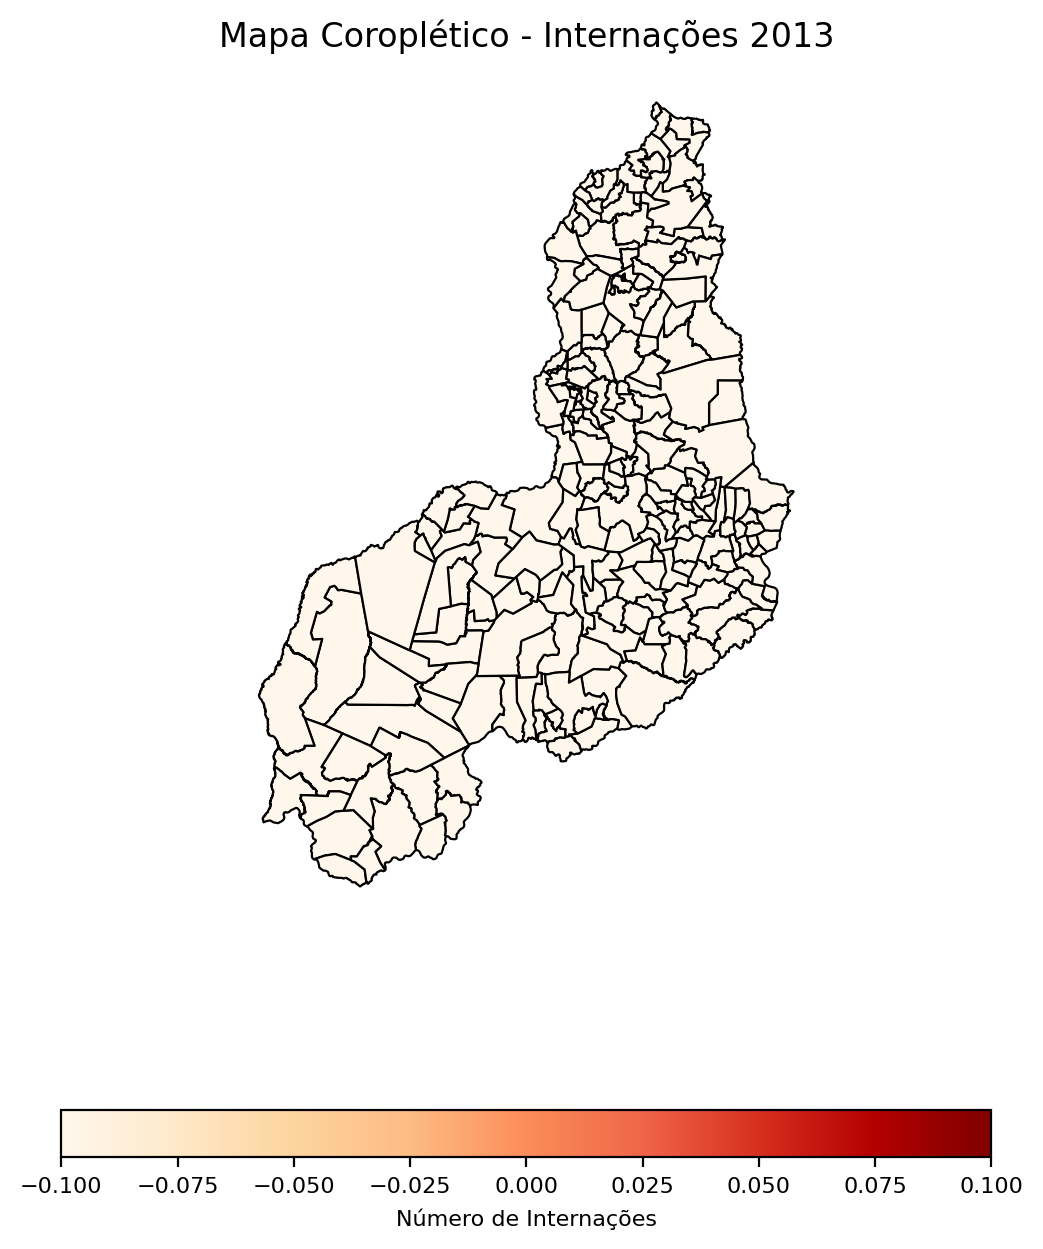

Variável 'internacoes' é constante ou quase constante. Índice de Moran não pode ser calculado.
Moran's I é nan (possivelmente devido à variabilidade nula). Scatterplot não pode ser gerado.


/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:227: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


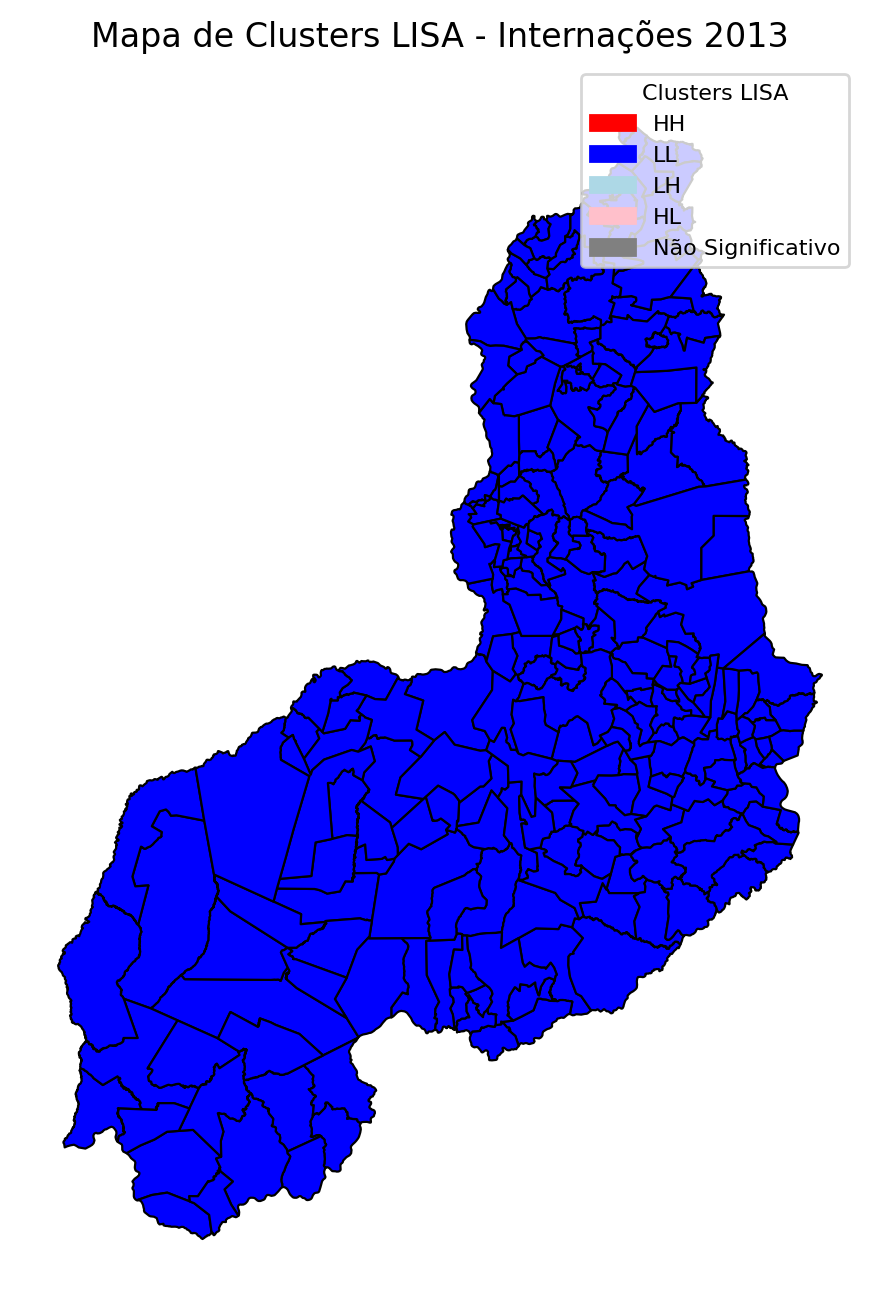


Analisando o ano 2021...


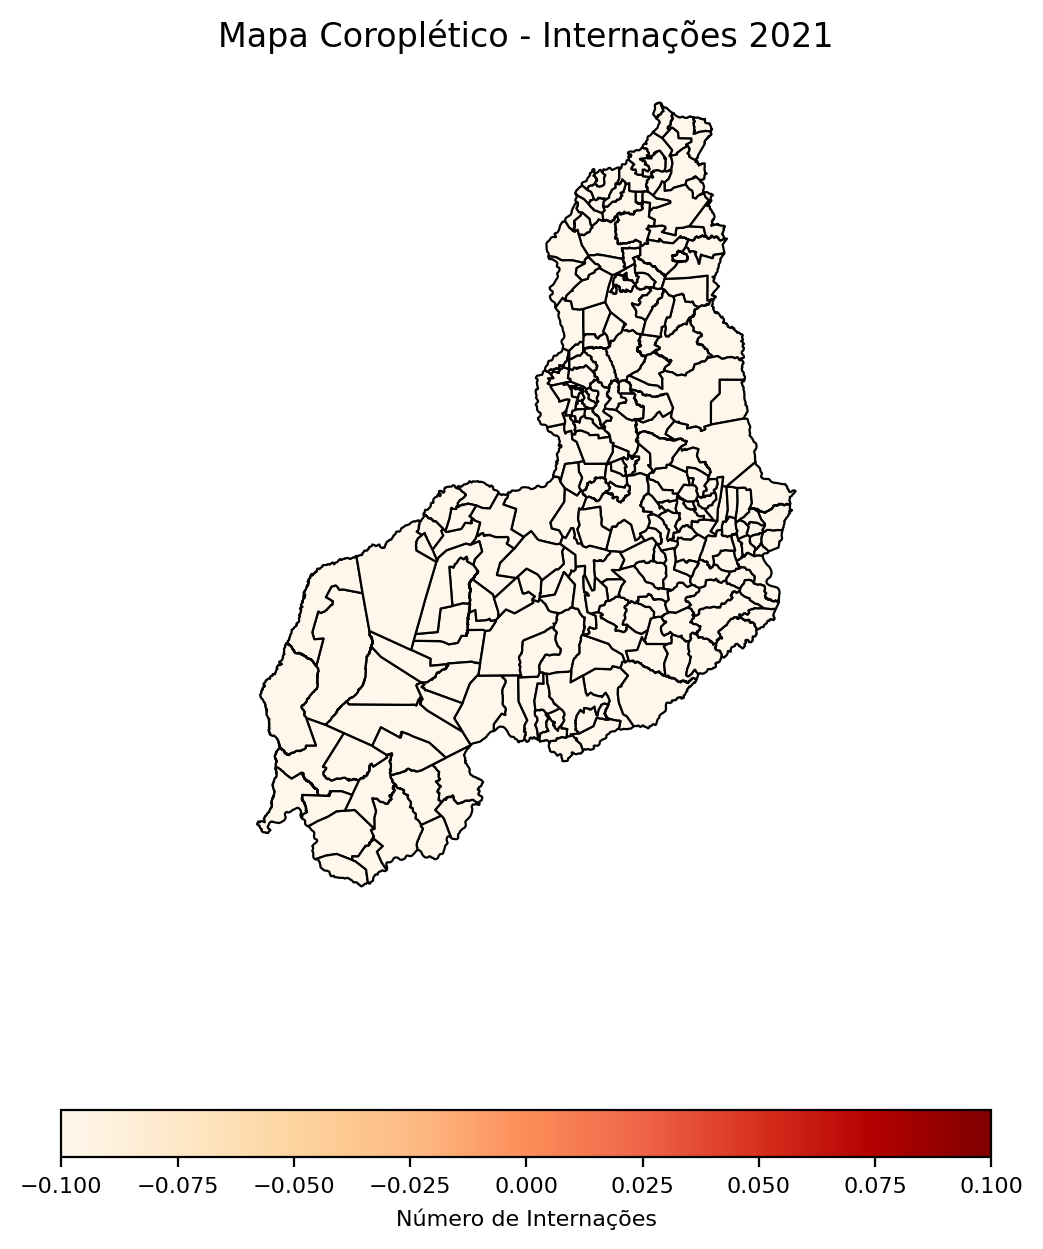

Variável 'internacoes' é constante ou quase constante. Índice de Moran não pode ser calculado.
Moran's I é nan (possivelmente devido à variabilidade nula). Scatterplot não pode ser gerado.


/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:270: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/home/lulu/myenv/lib/python3.12/site-packages/esda/moran.py:227: RuntimeWarning: invalid value encountered in divide
  self.z /= sy


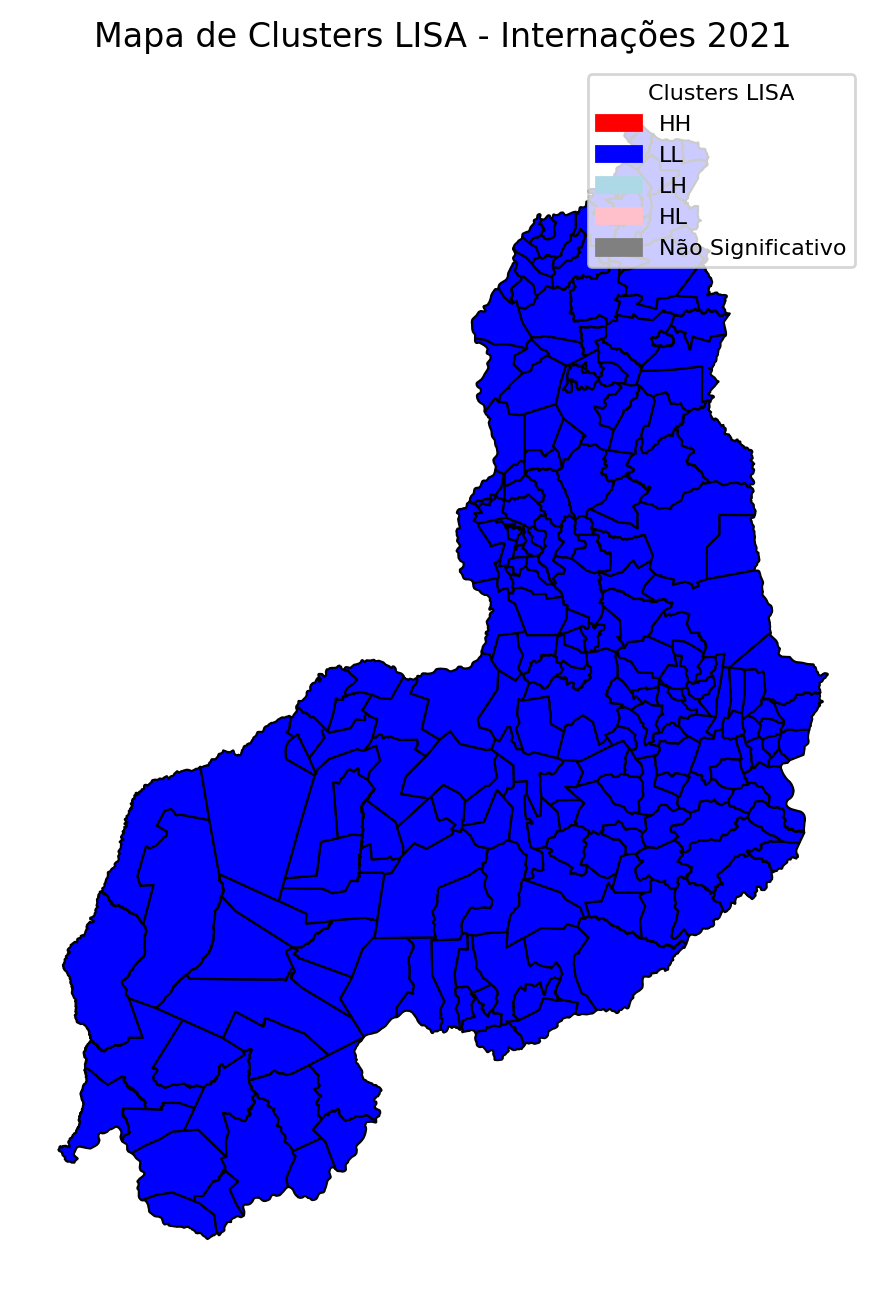

In [29]:
analyze_years([2013, 2021])